In [34]:
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)

files = glob.glob('./server_results/grid_search/*.csv')
files = glob.glob('./server_results/grid_search_ext/*.csv')

In [35]:
def handle_matcher_names(df):



    # substitutions = {
    #     'header_values_default': 'H+V def.',
    #     'header_values_simple': 'H+V simp.',
    #     'header_values_verbose': 'H+V ver.',
    #     'header_values_repeat': 'H+V rep.',
    #     'header_values_prefix': 'H+V pref.',
    #     'header_only': 'V only',
    #     'header_values_verbose_notype': 'H+V ver. notyp',
    #     'header_values_columnvaluepair_notype': 'H+V col-val notyp',
    #     'header_header_values_repeat_notype': 'H+V rep. notyp',
    #     'header_values_default_notype': 'H+V def. notyp',
    # }

    substitutions = {
        'header_values_default': 'Default (Type)',
        'header_values_verbose': 'Verbose (Type)',
        'header_values_repeat': 'Repeat (Type)',
        'header_values_prefix': 'Prefix (Type)',
        'header_only': 'Column only',
        'header_values_verbose_notype': 'Verbose',
        'header_values_columnvaluepair_notype': 'ColVal Pairs',
        'header_header_values_repeat_notype': 'Repeat',
        'header_values_default_notype': 'Default',
    }

    df['encoding_mode'] = df['encoding_mode'].replace(substitutions)

    # print(df['encoding_mode'].unique())

    to_show = [
        #'Default (Type)',
        'Default',
        'Verbose',
        'Repeat',
        'ColVal Pairs',
        'Column only',
    ]

#     ['Default (Type)' 'Prefix (Type)' 'Repeat (Type)' 'Verbose (Type)'
#  'Column only' 'Verbose' 'ColVal Pairs' 'Repeat' 'Default']

    df = df[df['encoding_mode'].isin(to_show)].copy()


    
    
    df['sampling_mode'] = df['sampling_mode'].str.title()
    df['sampling_mode'] = df['sampling_mode'].str.replace('_Sampling', '')
    df = df[df['sampling_mode'] != 'Mixed'].copy()

    sampling_size = 10
    df = df[df['sampling_size'] == sampling_size].copy()

    df.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'}, inplace=True)
    df.rename(columns={'mrr': 'MRR'}, inplace=True)

    return df


def best_aggregate(df, metric='mrr'):

    df_grouped = df.groupby(['encoding_mode', 'sampling_mode', 'sampling_size'])[
        metric].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
    # df_grouped = df.groupby([ 'sampling_mode','encoding_mode', 'sampling_size'])[metric].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
    df_grouped = df_grouped.sort_values(by='mean', ascending=False)
    print(df_grouped.head(20).to_string())
    return df_grouped



def plot(df, ax, x, hue, group, y, datasetname, figsize=(15, 5), legend=False, save=None):
    

    order = df.groupby(x)[y].mean().sort_values(ascending=False).index

    hue_order = df.groupby(hue)[y].mean().sort_values(ascending=False).index

    sns.boxplot(
        data=df,
        x=x,
        hue=hue,
        y=y,
        ax=ax,
        palette=sns.color_palette("Set2"),  # Use a better palette
        order=order,
        hue_order=hue_order
        # , showfliers=False
        ,fliersize=0.5

    )

    #ax.set_xlabel(x.replace('_', ' ').title(), fontsize=14)
    ax.set_xlabel('Column representation', fontsize=14)

    ax.set_ylabel(y.upper(), fontsize=14)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    if legend:
        ax.set_xlabel('')

    if legend:
        ax.legend(
            title=hue.replace('_mode', '').title(),
            fontsize=14,
            title_fontsize=14,
            loc='lower center',
            bbox_to_anchor=(0.48, 0.98),
            ncol=len(df[hue].unique()),
            frameon=False
        )
    else:
        ax.get_legend().remove()

    sns.despine()



def plot_grouped_bar(df, x, hue, group, metrics, datasetname, figsize=(9, 8), save=None):

    fig, axis = plt.subplots(len(metrics),1 , figsize=figsize)

    for i, metric in enumerate(metrics):
        ax = axis[i]
        plot(df, ax, x, hue, group, metric, datasetname, figsize=figsize, legend=(i==0), save=None)


    if save is not None:
        fig.savefig(save, format='pdf', dpi=300)

    plt.tight_layout()
    plt.show()
   

In [36]:
all_dfs_list = []
datasetnames = []
for file in files:
    datasetname = file.split('_')[0]
    datasetname = file.split('/')[-1].split('_')[0]
    datasetnames.append(datasetname)
    df = pd.read_csv(file)
    df = handle_matcher_names(df)
    
    all_dfs_list.append(df)

    if datasetname == 'GDC':
        gdc_df = df

all_dfs = pd.concat(all_dfs_list)



In [37]:
# for i,df in enumerate(all_dfs_list):
#     datasetname =datasetnames[i]
#     if datasetname != 'GDC':
#         continue
#     print('Results for', datasetname)
#     plot_grouped_bar(df,  'encoding_mode', 'sampling_mode','sampling_size', metrics,datasetname, figsize=(10, 6), save = "figures/grid_search_retriever_encmodes.pdf")
#     best_aggregate(df, metric1)

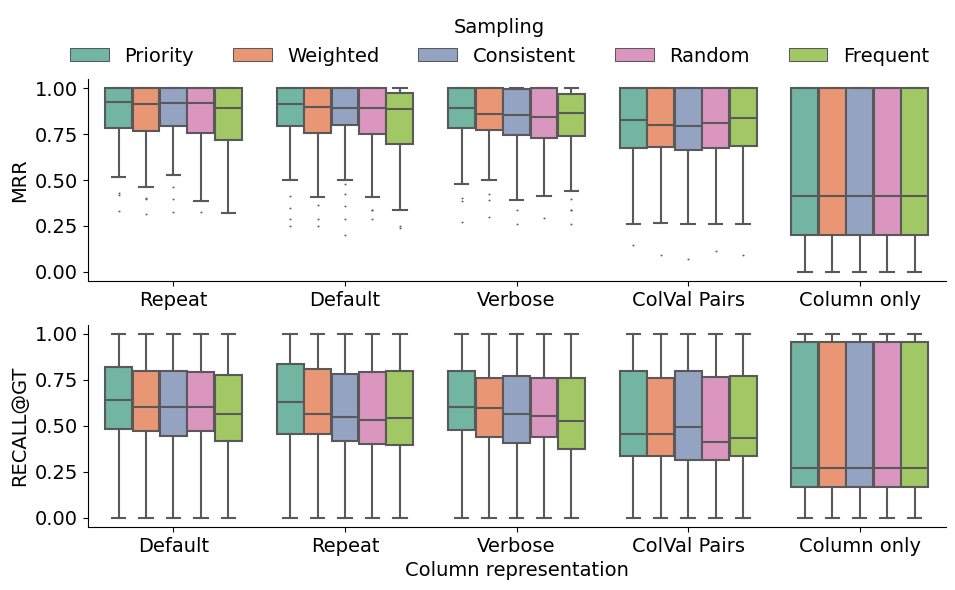

   encoding_mode sampling_mode  sampling_size      mean    median       min  max       std
17        Repeat      Priority             10  0.874038  0.925463  0.330952  1.0  0.151364
15        Repeat    Consistent             10  0.869013  0.916667  0.322689  1.0  0.151647
18        Repeat        Random             10  0.860021  0.916667  0.323696  1.0  0.156112
22       Verbose      Priority             10  0.858606  0.891732  0.270408  1.0  0.155447
19        Repeat      Weighted             10  0.856399  0.910317  0.316545  1.0  0.159818
12       Default      Priority             10  0.855640  0.914389  0.250000  1.0  0.170617
10       Default    Consistent             10  0.850975  0.891194  0.200000  1.0  0.167667
14       Default      Weighted             10  0.847371  0.896970  0.250000  1.0  0.170120
24       Verbose      Weighted             10  0.843025  0.860714  0.297619  1.0  0.156108
16        Repeat      Frequent             10  0.838824  0.888889  0.318094  1.0  0.168617

,encoding_mode,sampling_mode,sampling_size,mean,median,min,max,std
17,Repeat,Priority,10,0.874038,0.925463,0.330952,1.0,0.151364
15,Repeat,Consistent,10,0.869013,0.916667,0.322689,1.0,0.151647
18,Repeat,Random,10,0.860021,0.916667,0.323696,1.0,0.156112
22,Verbose,Priority,10,0.858606,0.891732,0.270408,1.0,0.155447
19,Repeat,Weighted,10,0.856399,0.910317,0.316545,1.0,0.159818
12,Default,Priority,10,0.855640,0.914389,0.250000,1.0,0.170617
10,Default,Consistent,10,0.850975,0.891194,0.200000,1.0,0.167667
14,Default,Weighted,10,0.847371,0.896970,0.250000,1.0,0.170120
24,Verbose,Weighted,10,0.843025,0.860714,0.297619,1.0,0.156108
16,Repeat,Frequent,10,0.838824,0.888889,0.318094,1.0,0.168617


In [38]:
metric1 = 'MRR'
metric2 = 'Recall@GT'
metrics = [metric1, metric2]

plot_grouped_bar(all_dfs,  'encoding_mode', 'sampling_mode','sampling_size', metrics, 'Real-world datasets', figsize=(10, 6), save = "figures/grid_search_retriever_encmodes.pdf")
best_aggregate(all_dfs, metric1)



In [39]:
real_datasets = ['gdc_studies', 'Musicians', 'Magellan']
fabricated_datasets = ['ChEMBL', 'OpenData', 'TPC-DI']

df_real = all_dfs[all_dfs['dataset'].isin(real_datasets)]
df_fabricated = all_dfs[all_dfs['dataset'].isin(fabricated_datasets)]

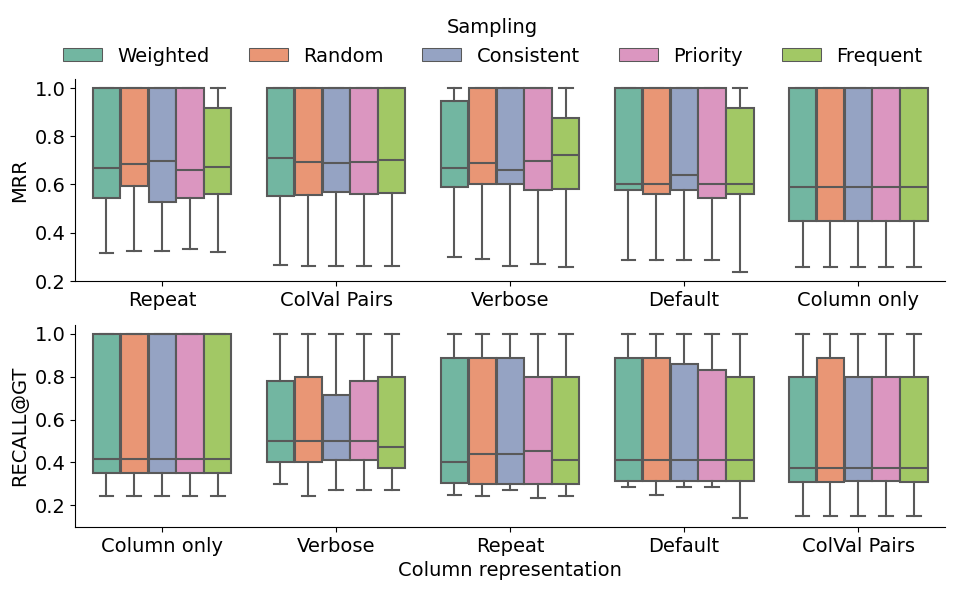

   encoding_mode sampling_mode  sampling_size      mean    median       min  max       std
15        Repeat    Consistent             10  0.724321  0.697917  0.322689  1.0  0.238376
23       Verbose        Random             10  0.723584  0.686979  0.292857  1.0  0.231412
4   ColVal Pairs      Weighted             10  0.721380  0.708406  0.264010  1.0  0.253487
18        Repeat        Random             10  0.717639  0.683807  0.323696  1.0  0.231370
3   ColVal Pairs        Random             10  0.717196  0.692308  0.261905  1.0  0.254284
1   ColVal Pairs      Frequent             10  0.715505  0.700000  0.261905  1.0  0.254001
19        Repeat      Weighted             10  0.714863  0.667708  0.316545  1.0  0.240463
17        Repeat      Priority             10  0.714505  0.660196  0.330952  1.0  0.235225
24       Verbose      Weighted             10  0.713704  0.666667  0.297619  1.0  0.226779
20       Verbose    Consistent             10  0.711738  0.659328  0.261905  1.0  0.235773

,encoding_mode,sampling_mode,sampling_size,mean,median,min,max,std
15,Repeat,Consistent,10,0.724321,0.697917,0.322689,1.0,0.238376
23,Verbose,Random,10,0.723584,0.686979,0.292857,1.0,0.231412
4,ColVal Pairs,Weighted,10,0.721380,0.708406,0.264010,1.0,0.253487
18,Repeat,Random,10,0.717639,0.683807,0.323696,1.0,0.231370
3,ColVal Pairs,Random,10,0.717196,0.692308,0.261905,1.0,0.254284
1,ColVal Pairs,Frequent,10,0.715505,0.700000,0.261905,1.0,0.254001
19,Repeat,Weighted,10,0.714863,0.667708,0.316545,1.0,0.240463
17,Repeat,Priority,10,0.714505,0.660196,0.330952,1.0,0.235225
24,Verbose,Weighted,10,0.713704,0.666667,0.297619,1.0,0.226779
20,Verbose,Consistent,10,0.711738,0.659328,0.261905,1.0,0.235773


In [ ]:
# plot_grouped_bar(df_real,  'encoding_mode', 'sampling_mode','sampling_size', metrics, 'Real-world datasets', figsize=(10, 6), save = "figures/grid_search_retriever_encmodes.pdf")
# best_aggregate(df_real, metric1)

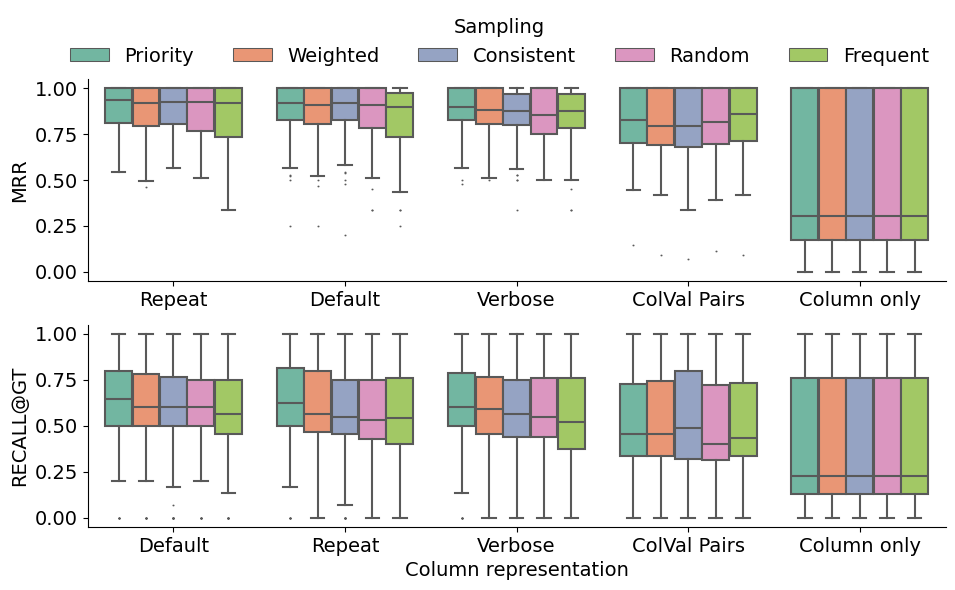

   encoding_mode sampling_mode  sampling_size      mean    median       min  max       std
17        Repeat      Priority             10  0.898294  0.932026  0.542444  1.0  0.116571
15        Repeat    Consistent             10  0.890573  0.922222  0.564561  1.0  0.119661
18        Repeat        Random             10  0.881165  0.924242  0.512667  1.0  0.128907
22       Verbose      Priority             10  0.880448  0.895652  0.479017  1.0  0.124120
12       Default      Priority             10  0.879758  0.916667  0.250000  1.0  0.139741
19        Repeat      Weighted             10  0.877258  0.916667  0.461616  1.0  0.131829
10       Default    Consistent             10  0.873831  0.916667  0.200000  1.0  0.141433
14       Default      Weighted             10  0.869596  0.909091  0.250000  1.0  0.142791
24       Verbose      Weighted             10  0.863305  0.881159  0.500000  1.0  0.132343
13       Default        Random             10  0.861591  0.906667  0.333333  1.0  0.148680

,encoding_mode,sampling_mode,sampling_size,mean,median,min,max,std
17,Repeat,Priority,10,0.898294,0.932026,0.542444,1.0,0.116571
15,Repeat,Consistent,10,0.890573,0.922222,0.564561,1.0,0.119661
18,Repeat,Random,10,0.881165,0.924242,0.512667,1.0,0.128907
22,Verbose,Priority,10,0.880448,0.895652,0.479017,1.0,0.124120
12,Default,Priority,10,0.879758,0.916667,0.250000,1.0,0.139741
19,Repeat,Weighted,10,0.877258,0.916667,0.461616,1.0,0.131829
10,Default,Consistent,10,0.873831,0.916667,0.200000,1.0,0.141433
14,Default,Weighted,10,0.869596,0.909091,0.250000,1.0,0.142791
24,Verbose,Weighted,10,0.863305,0.881159,0.500000,1.0,0.132343
13,Default,Random,10,0.861591,0.906667,0.333333,1.0,0.148680


In [ ]:
# plot_grouped_bar(df_fabricated,  'encoding_mode', 'sampling_mode','sampling_size', metrics, 'Real-world datasets', figsize=(10, 6), save = "figures/grid_search_retriever_encmodes.pdf")
# best_aggregate(df_fabricated, metric1)